# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
          
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    global recent_hough_lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    recent_hough_lines.append(lines)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, recent_hough_lines[-25:])
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
all_left_slopes = np.empty([0,1])
all_right_slopes = np.empty([0,1])
all_left_coordinates = np.empty([0,4])
all_right_coordinates = np.empty([0,4])
recent_hough_lines = []

def draw_lines(img, images, color=[255, 0, 0], thickness=10):
    global all_left_coordinates, all_right_coordinates
    left_coordinates = np.empty([0,4])
    right_coordinates = np.empty([0,4])
    left_slopes = np.empty([0,1])
    right_slopes = np.empty([0,1])
    for image in images:
        for line in image:
            coordinates = np.array([line[0]])
            slope = get_slope(coordinates[0,:])
            if slope > 0 and check_for_outliers(slope, all_right_slopes):
                right_coordinates = np.append(right_coordinates, coordinates, axis=0)
                right_slopes = np.append(right_slopes, slope)

            elif slope < 0 and check_for_outliers(slope, all_left_slopes):
                left_coordinates = np.append(left_coordinates, coordinates, axis=0)
                left_slopes = np.append(left_slopes, slope)
                
    if len(left_coordinates) == 0 or len(right_coordinates) == 0:
        return
    
    left_coordinate_averages = np.mean(left_coordinates, axis=0)
    right_coordinate_averages = np.mean(right_coordinates, axis=0)

    all_left_coordinates = np.append(all_left_coordinates, np.array([left_coordinate_averages]), axis=0)
    all_right_coordinates = np.append(all_right_coordinates, np.array([right_coordinate_averages]), axis=0)
    average_all_left_coordinates = get_average_coordinates(left_coordinate_averages, all_left_coordinates)
    average_all_right_coordinates = get_average_coordinates(right_coordinate_averages, all_right_coordinates)

    left_slope = np.nanmean(left_slopes)
    right_slope = np.nanmean(right_slopes)
    
    average_left_slope = get_average_slope(left_slope)
    average_right_slope = get_average_slope(right_slope)
    
    left_y_intercept = get_y_intercept(average_all_left_coordinates, average_left_slope)
    right_y_intercept = get_y_intercept(average_all_right_coordinates, average_right_slope)
    
    image_bottom = img.shape[0]
    left_coordinates = get_draw_line_coordinates(average_left_slope, left_y_intercept, image_bottom) 
    right_coordinates = get_draw_line_coordinates(average_right_slope, right_y_intercept, image_bottom) 
    cv2.line(img, left_coordinates[0], left_coordinates[1], color, thickness)
    cv2.line(img, right_coordinates[0], right_coordinates[1], color, thickness)

def get_slope(coordinates):
    x1 = coordinates[0]
    y1 = coordinates[1]
    x2 = coordinates[2]
    y2 = coordinates[3]
    return (y2-y1) / (x2-x1)

def get_y_intercept(coordinates, slope):
    return coordinates[1] - (slope * coordinates[0]) 

def get_draw_line_coordinates(slope, y_intercept, img_height):
    y1 = int(img_height)
    x1 = int((y1 - y_intercept) / slope)
    y2 = int((img_height / 2) * 1.20)
    x2 = int((y2 - y_intercept) / slope)
    return [(x1, y1), (x2, y2)]


def get_average_slope(slope):
    global all_left_slopes, all_right_slopes
    if slope > 0:
        all_right_slopes = get_weighted_slope(slope, all_right_slopes)
        return all_right_slopes[len(all_right_slopes)-1]
    else:
        all_left_slopes = get_weighted_slope(slope, all_left_slopes)
        return all_left_slopes[len(all_left_slopes)-1]

def get_weighted_slope(slope, all_slopes):
    weight = .4
    if len(all_slopes) > 2:
        slope = weight*slope + (1-weight)*np.mean(all_slopes[len(all_slopes)-5:])
    return np.append(all_slopes, slope)
        
        
def get_average_coordinates(current_coordinates, all_coordinates):
    weight = .4
    averaged = weight*current_coordinates + (1-weight)*np.mean(all_coordinates[len(all_coordinates)-5:,:], axis=0)
    return averaged
        
def check_for_outliers(slope, slopes):
    if len(slopes) < 50:
        return True
    slopes = np.asarray(slopes)
    return abs(slope - np.mean(slopes)) < (3 * np.std(slopes))

def reject_outliers(slopes, m=1):
    slopes = np.array(slopes)
    if(slopes.size > 50):
        slopes = slopes[abs(slopes - np.mean(slopes)) < m * np.std(slopes)]
    return slopes



## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


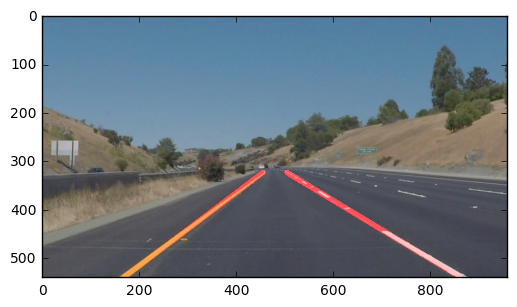

In [5]:
import os
from PIL import Image
import numpy as np
i = 0
def clear_globals():
    global all_left_slopes, all_right_slopes, recent_hough_lines
    all_left_slopes = []
    all_right_slopes = []
    recent_hough_lines = []

def get_image(image_name):
    return mpimg.imread('test_images/' + image_name)

def get_masked_image(img):
    imshape = img.shape
    vertices = get_vertices(imshape[0], imshape[1])
    return region_of_interest(img, vertices)
    
def get_vertices(image_height, image_width):    
    left_top = [image_width/2 * .98, image_height/2 * 1.16]
    right_top = [image_width/2 * 1.02, image_height/2 * 1.16]
    left_bottom = [0, image_height * .85]
    right_bottom = [image_width, image_height * .85]
    return np.array([[(left_top), (left_bottom), (right_bottom), (right_top)]], np.int32)
    
def highlight_image(img):
    gray_image = grayscale(img)
    blurred_image = gaussian_blur(gray_image, 5)
    edges = canny(blurred_image, 50, 150)
    masked_image = get_masked_image(edges)
    lines = hough_lines(masked_image, 2, np.pi/180, 25, 40, 20)
    weighted_image = weighted_img(lines, img)
    return weighted_image

image_names = os.listdir("test_images/")
images = []

for name in image_names:
    clear_globals()
    img = get_image(name)
    highlighted_image = highlight_image(img)
    images.append(highlighted_image)
    

#printing out some stats and plotting
print('This image is:', type(images[1]), 'with dimesions:', images[0].shape)
plt.imshow(images[3])  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    return highlight_image(image)

Let's try the one with the solid white lane on the right first ...

In [8]:
clear_globals()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 26.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:27<00:00, 25.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 26.7 s, sys: 2.78 s, total: 29.5 s
Wall time: 27.6 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 83%|████████▎ | 208/251 [00:15<00:02, 15.82it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))